# Conexión MySQL y Python para obtener la información
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.

#### **Importar librerias**

Para conectar la base de datos, necesitarè instalar el conector de mysql en python. Esto lo hago mediante el comando 'pip install mysql.connector' desde la consola de powershell.
Asi mis mismo iré instalando las librerias para visualización a lo largo del sprint.

In [1]:
# IMPORTAR LAS LIBRERIAS NECESARIAS
import mysql.connector
import pandas as pd
from datetime import datetime
from tabulate import tabulate
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr # lo utilizaré para establecer si existe relacion en alguna variable

## Crear conexión y obtener las tablas

- Para conectar python con MySQL debo establercer la conexión a partir del conector instalado y entregando las credeciales de acceso a la base de datos.
- La base de datos que utilizaré se llama 'trades4' y eso me dará acceso a cada una de las dataframes.
- El siguiente paso es obtener las tablas para obtener los dataframes. 
- a cada tabla la llamaré 'df_{Nombre_de_tabla}

In [2]:
# CREO UNA CONEXIÓN PARA LA BASE DE DATOS 'TRADES4'
cnx = mysql.connector.connect(
    user='root',
    password='250301',
    host='localhost',
    database='trades4')
cursor = cnx.cursor()

# Obtener nombres de las tablas y las almaceno en una lista
cursor.execute("SHOW TABLES")
table_names = [table_name for (table_name,) in cursor.fetchall()] # display(table_names)
print(table_names)
# Obtener DataFrames de las tablas
dfs = {}
for table_name in table_names:
    cursor.execute(f"SELECT * FROM {table_name}")
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    dfs[table_name] = df

# Crear variables globales para cada DataFrame
for table_name, df in dfs.items():
    globals()[f"df_{table_name}"] = df

# Cerrar cursor y conexión
cursor.close()
cnx.close()


['card_status', 'companies', 'credit_cards', 'product_tx', 'products', 'transactions', 'users']


# Ejercicio 1: Mostrar una variable numérica

#### **Situación de trabajo** 
La empresa desea verificar y describir las edades de los usuarios, estableciendo variables numéricas para analizarlas al máximo. Esto es necesario para desarrollar una estrategia que permita mejorar los productos y plataformas dirigidos a esta demografía.

#### **Desarrollo:** 
1. Primer paso:
   - De la tabla `df_users` obtendré la información de la fecha de nacimiento y con ello calcularé la edad de cada usuario.
2. Segundo paso:
   - A partir de la edad realizaré un boxplot graficando la mediana, percentil 25 y 75
   - Tambien agregaré en el grafico el promedio, edad mínima y máxima. 

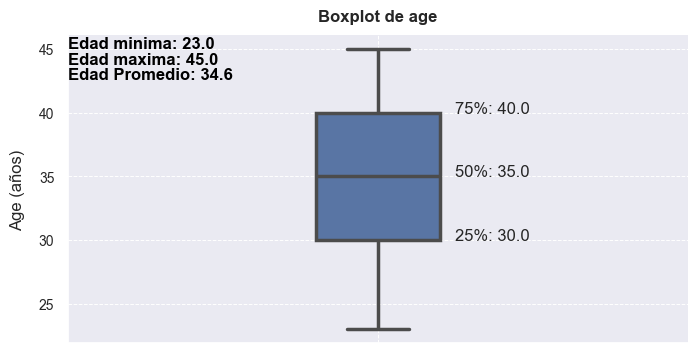

In [3]:
# FUNCIÓN PARA CONVERTIR 'BIRTH_DATE' A FORMATO DE FECHA Y CALCULAR LA EDAD EN AÑOS
df_users['birth_date'] = pd.to_datetime(df_users['birth_date'], format='%b %d, %Y')
df_users['age'] = datetime.now().year - df_users['birth_date'].dt.year

# FUNCIÓN PARA CREAR UN BOXPLOT
def age_boxplot(df, column):
    sns.set()
    plt.figure(figsize=(8, 4))
    
    # Crear el boxplot
    ax = sns.boxplot(y=df[column], width=0.2, fliersize=5, linewidth=2.5)
    ax.set_title(f'Boxplot de {column}', fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel(f'{column.capitalize()} (años)', fontsize=12, labelpad=10)
    ax.grid(True, linestyle='--', linewidth=0.7)
    ax.yaxis.set_tick_params(labelsize=10)
    sns.despine(top=True, right=True)
    
    # Anotar cuartiles a la derecha
    quartiles = df[column].quantile([0.25, 0.5, 0.75])
    for q, value in quartiles.items():
        label = f'{int(q * 100)}%: {value:.1f}'
        ax.text(0.125, value, label)
    
    # Anotar mínimo, máximo y promedio a la izquierda
    stats = {
        'Edad minima': df[column].min(),
        'Edad maxima': df[column].max(),
        'Edad Promedio': df[column].mean()
    }
    
    # Calcular posición vertical para los textos
    max_value = max(df[column].max(), max(quartiles))
    min_value = min(df[column].min(), min(quartiles))
    vertical_position = max_value + 0.1 * (max_value - min_value)
    
    for i, (stat, value) in enumerate(stats.items(), start=1):
        ax.text(-0.5, vertical_position - i * 1.2, f'{stat}: {value:.1f}', verticalalignment='top', size='medium', color='black', weight='semibold')
    
    plt.show()
age_boxplot(df_users, 'age')



#### **Descripción y Análisis:**

1. **Enfoque del Análisis:**
   El análisis se centra en las edades de los usuarios para determinar el perfil demográfico, utilizando un boxplot para mostrar la distribución de las edades junto con estadísticas resumidas como la edad media, mínima y máxima.

2. **Distribución de Edades:**
   La distribución de las edades de los usuarios revela una edad media de 34 años, con un rango que va desde los 23 hasta los 45 años. 

3. **Estadísticas Resumidas:**
   Los percentiles 25 y 75 se sitúan en 30 y 40 años, respectivamente, mientras que la mediana es de 35 años.

4. **Observación de Outliers:**
   No se observan outliers significativos en la distribución de las edades.



#### **Recomendaciones:**

1. **Segmentación de Productos:**
   Dado que la mayoría de los usuarios se encuentran entre los 30 y 40 años, recomendaría desarrollar productos y servicios específicamente adaptados a las necesidades y preferencias de este grupo etario.

2. **Estrategia de Marketing:**
   Implementaría campañas de marketing que destaquen las características y beneficios más relevantes para los usuarios de entre 23 y 45 años, utilizando canales y mensajes que resuenen con este grupo demográfico amplio y diverso.

3. **Plataformas y Experiencia del Usuario:**
   Propondría mejorar las plataformas digitales para hacerlas más intuitivas y funcionales para usuarios de 30 a 40 años. Esto garantizaría una experiencia de usuario óptima y adaptada a sus habilidades y expectativas tecnológicas.

4. **Monitoreo Continuo:**
   Recomendaría continuar monitoreando la distribución de edades para identificar cambios demográficos significativos que puedan requerir ajustes estratégicos.




# Ejercicio 2: Dos variables numéricas

#### **Situación:**

La empresa ha pedido complementar la informacion anterior solicitado un análisis para determinar la relación entre la edad de los usuarios y su capacidad de compra, representada por la cantidad de dinero que gastan. 

Para llevar a cabo este análisis, es necesario seleccionar dos variables numéricas: la edad de los usuarios y el monto de las compras, que se extraerá de la tabla transactions. El objetivo es identificar patrones y tendencias que puedan informar futuras estrategias de marketing y ventas.

#### **Desarrollo**
Para analizar esta relación, se deben realizar los siguientes pasos:

1. **Utilizar Tablas df_users y df_transactions:**
   Utilizaré tanto la tabla `df_users` como la tabla `df_transactions` para obtener la información necesaria.

2. **Calcular la Edad de los Usuarios:**
   Calcularé la edad de los usuarios a partir de sus fechas de nacimiento, de la misma manera que en cálculos previos.

3. **Unir Tablas por Identificador de Usuario:**
   Uniré las tablas `df_users` y `df_transactions` utilizando los identificadores de usuario (`user_id`).

4. **Generar Resumen Estadístico:**
   Generaré un resumen estadístico de las variables seleccionadas para el análisis.

5. **Visualizar Relación con Scatter Plot:**
   Visualizaré la relación entre la edad y la capacidad de compra mediante un diagrama de dispersión (scatter plot).


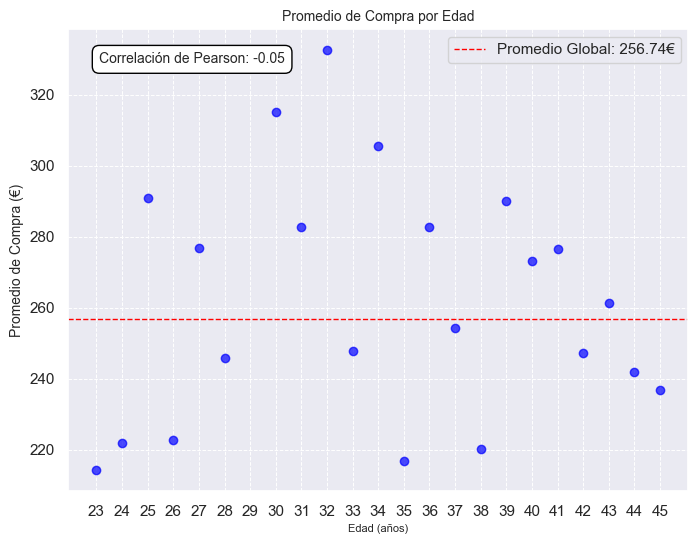

In [4]:
# CONVERTIR 'BIRTH_DATE' A FORMATO DE FECHA Y CALCULAR LA EDAD EN AÑOS
df_users['birth_date'] = pd.to_datetime(df_users['birth_date'], format='%b %d, %Y')
df_users['age'] = datetime.now().year - df_users['birth_date'].dt.year

# COMO ES UN 'OBJECT' HAGO LA CONVERSIÓN A 'FLOAT' PARA OBTENER LAS METRICAS:
df_transactions['amount'] = df_transactions['amount'].astype(float)

# Fusionar los DataFrames df_transactions y df_users en df_trans_users
df_trans_users = df_transactions.merge(df_users, left_on='user_id', right_on='id')

# Agrupar por edad y calcular el promedio de la cantidad
grouped_by_age = df_trans_users.groupby('age')['amount'].mean().reset_index()

# Calcular el promedio global de amount
global_average = df_trans_users['amount'].mean()

# Calcular correlación de Pearson entre edad y promedio de compra
correlation = grouped_by_age['age'].corr(grouped_by_age['amount'])

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(grouped_by_age['age'], grouped_by_age['amount'], marker='o', color='blue', alpha=0.7)

# Añadir la línea del promedio global
plt.axhline(y=global_average, color='red', linestyle='--', linewidth=1, label=f'Promedio Global: {global_average:.2f}€')

# Configurar título y etiquetas de ejes
plt.title('Promedio de Compra por Edad', fontsize=10)
plt.xlabel('Edad (años)', fontsize=8)
plt.ylabel('Promedio de Compra (€)', fontsize=10)

# Ajustar los ticks del eje X para incluir todas las edades
plt.xticks(grouped_by_age['age'])

# Agregar la correlación de Pearson dentro del gráfico
plt.text(0.05, 0.95, f'Correlación de Pearson: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True, linestyle='--', linewidth=0.7)
plt.show()

#### **Descripción y Análisis**

1. **Promedio y Mediana por Edad:**
   El gráfico de dispersión muestra el promedio de la cantidad gastada por edad, junto con líneas indicativas del promedio y la mediana global de las compras. La línea roja discontinua representa el promedio global de las compras, mientras que la línea verde discontinua representa la mediana global.

2. **Correlación de Pearson:**
   La correlación de Pearson entre la edad y el promedio de compra es baja, lo que indica que no hay una relación lineal fuerte entre estas dos variables. La correlación de Pearson es de -0.05, lo que sugiere una correlación negativa muy débil entre la edad y el promedio de compra. Esto indica que la edad no es un predictor significativo del comportamiento de compra en este conjunto de datos.

3. **Distribución de Compras:**
   Se observa que las compras promedio varían ligeramente con la edad, pero no hay un patrón claro que indique que las personas de cierta edad gastan significativamente más o menos en promedio. La mediana global se incluye para mostrar el punto medio de las compras, complementando el análisis del promedio.


#### **Recomendaciones**

1. **Segmentación de Productos y Marketing:**
   Dado que no hay una relación clara entre edad y cantidad gastada, recomendaría segmentar el mercado en base a otros factores demográficos y comportamentales. Las estrategias de marketing deberían considerar estos factores adicionales para personalizar las ofertas y campañas.

2. **Análisis Complementario:**
   Sugeriría realizar un análisis más detallado considerando otras variables como el ingreso, la ubicación geográfica y el tipo de producto comprado. Un análisis de segmentación más profundo podría revelar patrones que no son evidentes al observar solo la edad y el gasto.

3. **Monitoreo Continuo:**
   Propondría continuar monitoreando y actualizando los datos para captar cualquier cambio en el comportamiento de compra a lo largo del tiempo. Implementar herramientas de análisis predictivo podría ayudarnos a anticipar tendencias futuras basadas en el comportamiento histórico de los usuarios.



# Ejercicio 3: Una variable categórica.

#### **Situación:**

- Con el objetivo de investigar las compras perdidas y determinar la necesidad de desarrollar nuevas estrategias, se solicita una variable categórica que permita identificar estos casos. He seleccionado la variable "declined" ya que indica si las transacciones han sido rechazadas, lo cual permite evaluar si es necesario profundizar en este aspecto.

#### **Desarrollo:**

- **Transformación de la columna "declined" en variable categórica:**
  - La columna "declined" indica si una transacción fue rechazada (1) o no (0). Transformarla en una variable categórica ayuda en el análisis.

- **Pasos a seguir:**
  1. **Conversión:**
     - Convertir la columna 'declined' a una variable categórica asignando etiquetas "No rechazada" y "Rechazada".
     
  2. **Descripción y análisis:**
     - Calcular la frecuencia de valores y mostrar la tabla de frecuencias para entender la distribución de transacciones aceptadas y rechazadas.
     - Describir la variable categórica para obtener estadísticas descriptivas.
     - Crear un gráfico de barras para visualizar el número de transacciones aceptadas y rechazadas.

- **Objetivo:**
  - Obtener información crucial sobre el estado de las transacciones.
  - Entender la frecuencia y proporción de transacciones rechazadas.
  - Facilitar el análisis de la distribución de transacciones rechazadas respecto a otras variables (tipo de transacción, cantidad, momento del rechazo).
  - Identificar patrones y tendencias para ajustar políticas y mejorar la seguridad, reduciendo rechazos.

Transformar y describir esta variable nos permitirá tomar decisiones informadas y diseñar estrategias efectivas para optimizar el proceso de transacciones.

declined
0    500
1     87
Name: count, dtype: int64
count     587
unique      2
top         0
freq      500
Name: declined, dtype: object


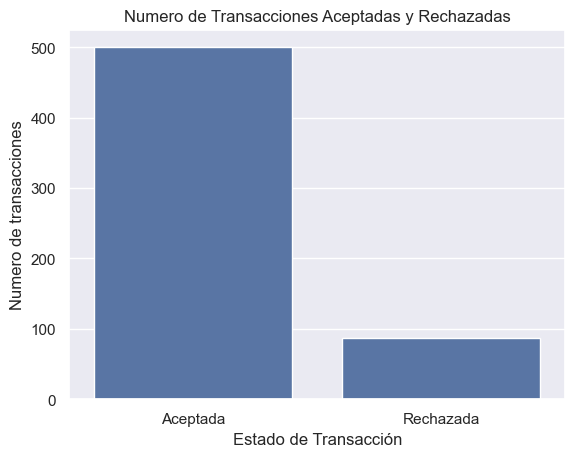

In [5]:
# Convertir la columna 'declined' a una variable categórica
df_transactions['declined'] = df_transactions['declined'].astype('category')

# Calcula la frecuencia de valores y  Muestra la tabla de frecuencias. Esto sera utilizado para saber los valores asocidados al gráfico.
freq_table = df_transactions['declined'].value_counts()
print(freq_table)

# Describir la variable categórica
description = df_transactions['declined'].describe()
print(description)

# Crear el gráfico de barras
sns.countplot(x='declined', data=df_transactions)
plt.title('Numero de Transacciones Aceptadas y Rechazadas')
plt.xlabel('Estado de Transacción')
plt.ylabel('Numero de transacciones')
plt.xticks(ticks=[0, 1], labels=['Aceptada', 'Rechazada'])
plt.show()

#### **Descripción y Análisis:**

1. **Análisis de la Variable "Declined":**
   Se analiza la variable categórica `declined` para identificar la frecuencia de transacciones aceptadas versus rechazadas. Esta variable indica si las transacciones fueron rechazadas (1) o no (0).

2. **Distribución de Transacciones:**
   Según los datos proporcionados, la mayoría de las transacciones (500 de 587) fueron aceptadas, mientras que 87 transacciones fueron rechazadas.

3. **Evaluación de Proporciones:**
   Este análisis inicial nos permite entender la distribución y la proporción de transacciones rechazadas en relación con las aceptadas.

4. **Importancia del Análisis:**
   Evaluar la frecuencia de transacciones rechazadas es crucial para entender la efectividad y la seguridad del proceso de transacciones.


#### **Recomendaciones:**

1. **Análisis de Causas de Rechazo:**
   Recomendaría investigar problemas de validación de tarjetas, límites de crédito insuficientes o medidas de seguridad activadas. Además, implementar sistemas de registro detallado de los motivos de rechazo podría ayudarnos a identificar patrones recurrentes y mejorar nuestra capacidad para abordar estos problemas de manera proactiva.

2. **Optimización de Políticas de Aprobación:**
   Sugeriría revisar y ajustar las políticas de aprobación de transacciones para minimizar los rechazos injustificados sin comprometer la seguridad. Esto podría incluir la actualización de los límites de crédito o la implementación de criterios más flexibles basados en comportamientos históricos de los usuarios, lo que permitiría una mayor tasa de aprobación sin sacrificar la integridad del sistema.

3. **Mejora en la Experiencia del Usuario:**
   Propondría ofrecer retroalimentación clara y rápida a los usuarios cuando una transacción sea rechazada, indicando los pasos necesarios para resolver el problema. Esto podría mejorar significativamente la satisfacción del cliente, ya que los usuarios se sentirían informados y apoyados durante el proceso de compra.

4. **Monitoreo Continuo y Evaluación de Resultados:**
   Establecería métricas clave para monitorear la tasa de rechazo de transacciones y su impacto en las ventas y la satisfacción del cliente. Además, realizar revisiones periódicas de los datos nos permitiría evaluar la efectividad de las estrategias implementadas y realizar ajustes según sea necesario para mantener y mejorar nuestros estándares de servicio.

5. **Capacitación y Actualización del Personal:**
   Recomendaría capacitar al personal involucrado en el procesamiento de transacciones para manejar eficazmente situaciones de rechazo y ofrecer soporte adecuado a los clientes afectados. Un personal bien entrenado podría mejorar la precisión en la toma de decisiones y reducir el número de rechazos erróneos, contribuyendo a una mejor experiencia del cliente.


# Ejercicio 4: Una variable categórica y una numérica.

####  **Situación:**

La empresa ha solicitado realizar un análisis detallado de los montos asociados a transacciones declinadas y no declinadas. El objetivo es identificar patrones y diferencias significativas entre estos dos grupos, lo cual será fundamental para optimizar estrategias empresariales relacionadas con la gestión de transacciones y la mejora de la experiencia del cliente.

#### **Desarrollo:**

Para obtener la visualización sigo los siguientes pasos:

1. **Selección de Variables:**
   Tomo las variables de 'declined' como categórica y 'amount' como continua.

2. **Gráfico de Barras:**
   Realizo un gráfico de barras que muestra la frecuencia de transacciones aceptadas y rechazadas.

3. **Boxplot:**
   Utilizo un boxplot para mostrar la distribución de los montos ('amount') para transacciones aceptadas y rechazadas.


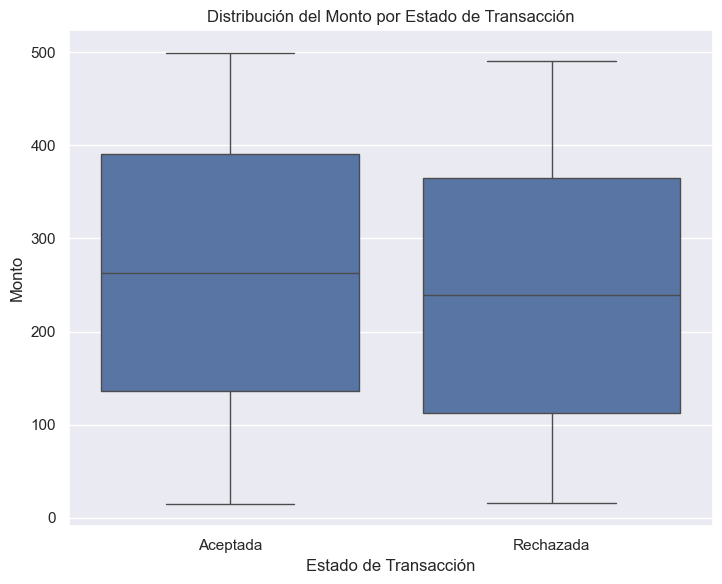

In [6]:
plt.figure(figsize=(14, 6))

# Gráfico de caja de la variable numérica 'amount' por la categórica 'declined'
plt.subplot(1, 2, 2)
sns.boxplot(x='declined', y='amount', data=df_transactions)
plt.title('Distribución del Monto por Estado de Transacción')
plt.xlabel('Estado de Transacción')
plt.ylabel('Monto')
plt.xticks(ticks=[0, 1], labels=['Aceptada', 'Rechazada'])

plt.tight_layout()
plt.show()


#### **Descripción y Análisis**

### **Descripción y Análisis**

Se examinan los montos de transacciones aceptadas y rechazadas a través de un boxplot.

- **Similitud de Montos**: La media, mediana y rangos intercuartílicos de ambos grupos son similares.
- **Desigualdad en Cantidad**: Las transacciones aceptadas son significativamente más numerosas que las rechazadas, lo cual no se refleja en el gráfico y puede llevar a interpretaciones incorrectas.

El gráfico muestra que las transacciones aceptadas tienen una mediana ligeramente superior a las rechazadas. La dispersión de los montos es similar en ambos grupos, indicando una variabilidad considerable en las transacciones.


#### **Recomendaciones**

1. **Ampliar el Análisis de Variables:**
   Recomendaría complementar nuestro análisis actual con otras variables como el tipo de transacción, el país de origen y el tipo de producto. Esto nos permitiría una comprensión más completa de los factores que influyen en la aprobación o rechazo de las transacciones, ofreciendo una perspectiva más detallada y precisa sobre los elementos que afectarían la decisión final.

2. **Optimización de Criterios de Aceptación:**
   Sugeriría revisar y ajustar los criterios de aceptación de transacciones. Un análisis más profundo de las transacciones rechazadas podría revelar patrones que permitirían modificar estos criterios, reduciendo así el número de rechazos sin comprometer la seguridad. Esta optimización podría conducir a una mayor eficiencia y una mejor tasa de aceptación.

3. **Estudio de Casos Específicos:**
   Realizar un estudio detallado de transacciones rechazadas podría ayudarnos a identificar posibles errores o áreas de mejora en el proceso de evaluación. Esto involucraría un análisis manual de una muestra representativa de transacciones rechazadas para comprender mejor las causas y aplicar soluciones específicas y efectivas.

4. **Implementación de Monitoreo Continuo:**
   Establecer un sistema de monitoreo continuo para las transacciones nos permitiría identificar y responder rápidamente a cualquier cambio en los patrones de aprobación y rechazo. Esto también facilitaría ajustes proactivos a las políticas de aprobación, asegurando que el sistema se mantenga eficiente y adaptado a las condiciones cambiantes del entorno.

5. **Capacitación del Personal:**
   Proporcionar capacitación adicional al personal encargado de la revisión de transacciones podría mejorar la precisión en la toma de decisiones y reducir la cantidad de transacciones válidas que serían rechazadas por error. Un personal bien capacitado sería fundamental para mantener la integridad



# Ejercicio 5: Dos variables categóricas.

#### **Situación:**

La empresa desea identificar la relación entre el pais de origen del ususario y el estado de las transacciones para optimizar sus esfuerzos y evitar pérdidas financieras.


#### **Desarrollo:**

Para abordar esta situación, se llevará a cabo el siguiente análisis:

1. **Unión de Tablas:**
   - Se unirá la tabla `df_transactions` con la tabla `df_users` utilizando la columna `user_id`. Esta unión permitirá enriquecer los datos de transacciones con información adicional de los usuarios, como el país de origen.
2. **Definir las Variables Categóricas:**
   - Me aseguro que se reconocerà como variable categorica. Esto facilitará el análisis y la visualización de los datos. 
3. **Análisis de Relación País - Estado de Transacciones:**
   - Se explorará cómo varía el estado de las transacciones (aceptadas o rechazadas) en diferentes países.
   - Esto permitirá identificar patrones y tendencias que puedan indicar áreas geográficas con mayores incidencias de transacciones rechazadas.

Este enfoque permitirá a la empresa tomar decisiones informadas y estratégicas para optimizar sus operaciones globales y reducir las pérdidas asociadas con transacciones rechazadas.



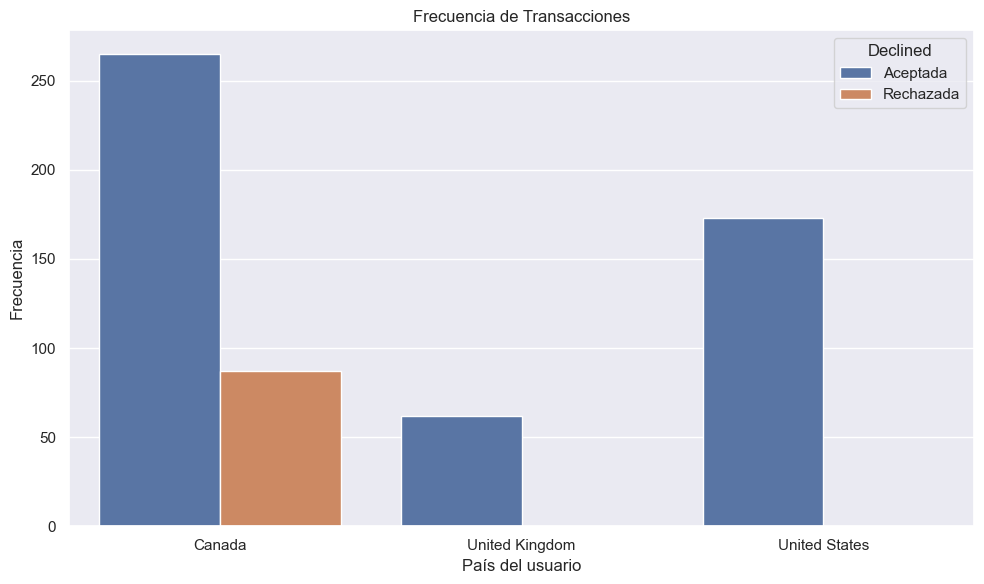

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Unir las tablas df_transactions y df_users usando user_id
merged_df = pd.merge(df_transactions, df_users, left_on='user_id', right_on='id', suffixes=('_transaction', '_user'))

# Convertir 'declined' y 'country' en variables categóricas
merged_df['declined'] = merged_df['declined'].astype('category')
merged_df['country'] = merged_df['country'].astype('category')

# Graficar los datos
plt.figure(figsize=(10, 6))

# Gráfico de conteo para las variables categóricas 'declined' y 'country'
sns.countplot(x='country', hue='declined', data=merged_df)
plt.title('Frecuencia de Transacciones')
plt.xlabel('País del usuario')
plt.ylabel('Frecuencia')
plt.legend(title='Declined', labels=['Aceptada', 'Rechazada'])

plt.tight_layout()
plt.show()

#### **Descripción y Análisis**

El análisis revela cómo el país de origen afecta el estado de las transacciones, identificando tendencias geográficas significativas.

- **Canadá**: Presenta transacciones rechazadas (80-90) y aceptadas (250-260).
- **Reino Unido**: Solo transacciones aceptadas (aproximadamente 50).
- **Estados Unidos**: Solo transacciones aceptadas (aproximadamente 150).

Los usuarios canadienses son los únicos con transacciones rechazadas, indicando un problema específico en su sistema de transacciones. Reino Unido y Estados Unidos no experimentan rechazos, aunque tienen menores frecuencias de transacciones aceptadas. Esto subraya la necesidad de abordar los rechazos en Canadá.


#### **Recomendaciones**

Dado que los usuarios con transacciones rechazadas provienen principalmente de Canadá, es fundamental desarrollar un plan de acción específico para abordar esta situación. Desde este punto, recomendaría:

1. **Alianzas Estratégicas con Bancos Locales:**
   Establecería alianzas estratégicas con bancos locales en Canadá para mejorar el proceso de aprobación de transacciones. Esto podría implicar la integración de sistemas o la negociación de acuerdos para facilitar las compras internacionales.

2. **Estudio Exhaustivo de Barreras:**
   Recomendaría realizar un estudio exhaustivo para identificar las posibles barreras que enfrentan los usuarios canadienses al realizar compras internacionales. Esto podría abarcar desde restricciones impuestas por los bancos hasta políticas de seguridad más estrictas.

3. **Adaptación del Sistema de Compras:**
   Propondría potenciar y adaptar el sistema de compras para asegurar que sea compatible y eficiente con las instituciones financieras canadienses. Esto podría incluir la implementación de métodos de pago alternativos que sean más aceptados en Canadá.

Es posible que las dificultades con los bancos canadienses se deban a políticas más restrictivas en comparación con las de Reino Unido o Estados Unidos. Abordar estas diferencias de manera proactiva podría mejorar significativamente la tasa de éxito en las transacciones y fortalecer la confianza de los usuarios canadienses en el sistema de compras.


# Ejercicio 6: Tres variables.

#### **Situacion:**

Como complemento al ejercicio anterior, la empresa solicita un análisis adicional que ofrezca más detalles sobre las transacciones aceptadas y rechazadas. Para ello, he decidido estudiar tres variables: el estado de las transacciones, el país de las compañias y el monto asociado a cada transacción. Al investigar estas variables, espero identificar patrones que puedan ayudar a mejorar el rendimiento de la empresa y optimizar sus procesos de transacción.

#### **Desarrollo:**

Este análisis utiliza tres variables clave: `declined` y `country` (categóricas) para distinguir el estado de las transacciones y su origen geográfico, y `amount` (numérica) para el valor de las transacciones.

1. Unimos `df_transactions` con `df_users` usando `user_id`.
2. Luego unimos el resultado con `df_companies` usando `business_id`.
3. Convertimos `declined` y `country` en variables categóricas.

Finalmente, creamos un gráfico de barras que muestra el monto total de las transacciones agrupadas por país y estado de transacción (aceptada o rechazada). Este gráfico identifica patrones y diferencias en el comportamiento de las transacciones, proporcionando información valiosa para mejorar las estrategias y operaciones de la empresa.


<Figure size 1200x800 with 0 Axes>

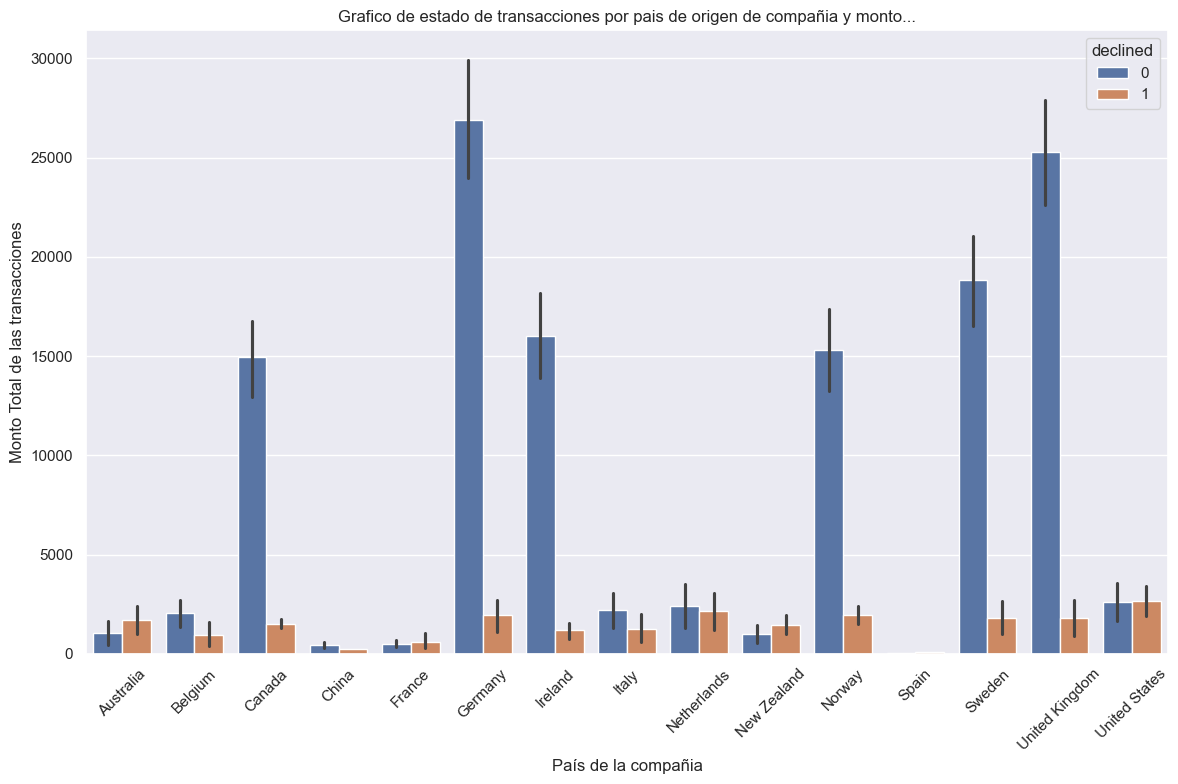

In [8]:
# Suponiendo que 'id' en df_companies corresponde a 'business_id' en df_transactions
merged_df = pd.merge(df_transactions, df_users, left_on='user_id', right_on='id', suffixes=('_transaction', '_user'))
merged_df = pd.merge(merged_df, df_companies, left_on='business_id', right_on='company_id')

# Convertir 'declined' y 'country' en variables categóricas
merged_df['declined'] = merged_df['declined'].astype('category')
merged_df['country_y'] = merged_df['country_y'].astype('category')

# Graficar los datos
plt.figure(figsize=(12, 8))

# Gráfico de barras agrupadas con 'amount' por 'country' y 'declined'
plt.figure(figsize=(12, 8))
sns.barplot(x='country_y', y='amount', hue='declined', data=merged_df, estimator=sum)
plt.title('Grafico de estado de transacciones por pais de origen de compañia y monto...')
plt.xlabel('País de la compañia')
plt.ylabel('Monto Total de las transacciones')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Descripción y Análisis**

1. **Comparación de Transacciones:**
   El gráfico compara transacciones aceptadas y rechazadas en diferentes países. Las transacciones aceptadas son significativamente más altas que las rechazadas, indicando una mayor cantidad de transacciones exitosas. Este análisis es útil para evaluar tendencias en el procesamiento de transacciones en distintas ubicaciones.

2. **Datos de España:**
   En España, no se ven datos significativos debido al bajo monto de compra, con solo dos transacciones registradas y ambas aprobadas.

3. **Países con Más Ventas:**
   Los países con más ventas incluyen Canadá, Alemania y Suecia.

4. **Estados Unidos:**
   En Estados Unidos, las ventas y los rechazos están equilibrados, lo que sugiere un problema específico en este mercado.

#### **Recomendaciones**

1. **Incrementar Presencia en España**:
   Aumentar la presencia en España para capitalizar el potencial de crecimiento y aumentar las transacciones aprobadas.

2. **Análisis de Mercado en China**:
   Identificar productos de interés y adaptar ofertas a las necesidades locales para aumentar ventas y reducir rechazos.

3. **Optimizar Proceso de Compra en Estados Unidos**:
   Revisar criterios de aprobación y ajustar sistemas de pago para mejorar el rendimiento en este mercado.

4. **Investigar Motivos de Rechazo**:
   Analizar y abordar las razones por las cuales las compañías declinan compras para reducir transacciones rechazadas.

5. **Estandarizar Formatos Internacionales**:
   Verificar y adaptar formatos y procedimientos para minimizar problemas específicos de cada país y mejorar la tasa de aprobación.

Estas recomendaciones ayudarán a optimizar los procesos de transacción, mejorar la experiencia del cliente y aumentar la eficiencia operativa en diferentes mercados.


# Ejercicio 7: Graficar un pairplot

#### **Situacion:**

La empresa ha solicitado un análisis detallado que muestre todas las relaciones posibles entre las variables numéricas en las transacciones, con el objetivo de identificar correlaciones y patrones que puedan mejorar la comprensión del comportamiento del usuario y optimizar los procesos de transacción. Para este análisis, se han seleccionado las variables amount (monto de la transacción), age_group (grupo de edad del usuario) y declined (estado de la transacción). El pairplot mostrará todas las relaciones posibles entre las variables numéricas, ayudando a identificar correlaciones y patrones entre las variables transaccionales.

#### **Desarrollo**

Para realizar el análisis, seguiré estos pasos:

1. **Importación de Librerías:** Importaré `pandas`, `seaborn`, `matplotlib.pyplot` y `datetime`.

2. **Unión de Tablas:** Uniré `df_transactions` con `df_credit_cards` usando `card_id`, luego agregaré `df_users` con `user_id`. Si es necesario, añadiré `df_companies` con `business_id`.

3. **Cálculo de Edad:** Calcularé la edad de los usuarios a partir de sus fechas de nacimiento.

4. **Agrupación de Edades:** Agruparé las edades en intervalos de 5 años.

5. **Definición de Variables:** Identificaré columnas categóricas y numéricas relevantes para el análisis.

6. **Filtrado del DataFrame:** Filtraré el DataFrame para incluir columnas seleccionadas y eliminar filas con valores faltantes.

7. **Creación del Pairplot:** Crearé un `pairplot` con `seaborn`, diferenciando por la columna `declined` y usando grupos de edad.

8. **Personalización del Gráfico:** Personalizaré el gráfico para mostrar edades en intervalos de 5 años en el eje x.

Estos pasos me permitirán analizar la relación entre la edad de los usuarios y su capacidad de compra.


Index(['country_trans', 'country_comp', 'declined', 'amount', 'age',
       'age_group'],
      dtype='object')


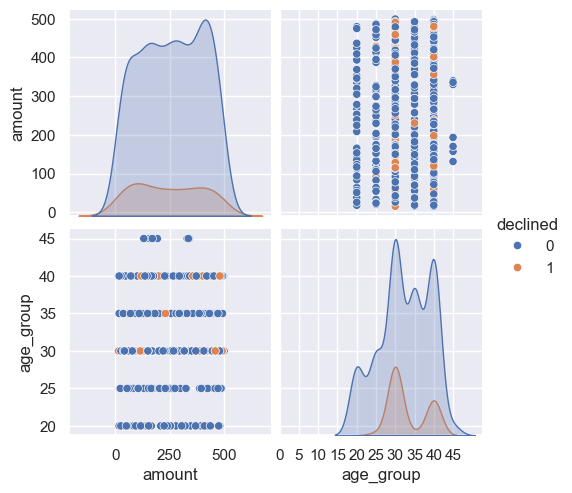

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Supongamos que ya tienes cargados los DataFrames df_companies, df_credit_cards, df_transactions, df_users

# Unir las tablas df_transactions y df_credit_cards
merged_df = pd.merge(df_transactions, df_credit_cards, left_on='card_id', right_on='id', suffixes=('_trans', '_card'))

# Unir df_users al merged_df
merged_df2 = pd.merge(merged_df, df_users, left_on='user_id_trans', right_on='id', suffixes=('_trans', '_user'))

# Si también necesitas incluir df_companies
merged_df3 = pd.merge(merged_df2, df_companies, left_on='business_id', right_on='company_id', how='left', suffixes=('_trans', '_comp'))

# Calcular la edad a partir de la fecha de nacimiento
merged_df3['birth_date'] = pd.to_datetime(merged_df3['birth_date'], format='%b %d, %Y')  # Convertir a tipo datetime si no está ya convertida
merged_df3['age'] = datetime.now().year - merged_df3['birth_date'].dt.year  # Calcular la edad en años

# Crear un grupo de edades cada 5 años
merged_df3['age_group'] = (merged_df3['age'] // 5) * 5

# Definir variables categóricas y numéricas
categorical_columns = ['country_trans', 'country_comp', 'declined']  # Incluir 'declined' como categórica
numeric_columns = ['amount', 'age', 'age_group']  # Incluir la edad y grupo de edad como columnas numéricas

# Filtrar el DataFrame para incluir solo las columnas relevantes y eliminar filas con NaN
plot_data = merged_df3[categorical_columns + numeric_columns].dropna()

# Imprimir las columnas seleccionadas
print(plot_data.columns)

# Crear el pairplot diferenciando por la columna 'declined' y utilizando el grupo de edad
sns.pairplot(plot_data, hue='declined', vars=['amount', 'age_group'])

# Personalizar el gráfico para que muestre la edad cada 5 años en el eje x
plt.xticks(range(0, int(plot_data['age'].max()) + 1, 5))

plt.show()


#### **Descripción y Análisis**

1. **Monto de las Transacciones:**
   La mayoría de las transacciones tienen un monto cercano a 500, con una mayor densidad en los montos más altos. Las transacciones rechazadas son menos frecuentes y suelen implicar montos más bajos en comparación con las transacciones aprobadas, que dominan tanto en cantidad como en monto.

2. **Edad de los Usuarios:**
   Se observa una concentración significativa en los grupos de edad de 25 a 45 años, indicando que este segmento demográfico realiza la mayoría de las transacciones. Aunque no se percibe una tendencia clara que relacione directamente el monto de la transacción con el grupo de edad, la distribución de las transacciones es bastante uniforme a lo largo de los diferentes grupos, con una ligera concentración en el rango de 25 a 45 años.

3. **Relación Edad y Monto:**
   Al examinar la relación específica entre el grupo de edad y el monto de la transacción, no se encuentra una correlación evidente. Las transacciones rechazadas muestran una mayor dispersión en diferentes grupos de edad y montos, lo que sugiere una evaluación de riesgo más diversa.

4. **Resumen:**
   Las transacciones aprobadas tienden a ser de montos más altos, reflejando mayor confianza en el sistema de aprobación para sumas significativas. La concentración de usuarios entre 25 y 45 años destaca este grupo como el más activo en términos de uso de tarjetas de crédito. La relación entre el monto de la transacción y la edad del usuario es menos definida, indicando una participación generalizada de todos los grupos de edad en transacciones de diversos montos.


#### **Recomendaciones**

1. **Optimización de Criterios de Aprobación**:
   Revisar y ajustar los criterios de aprobación para evitar rechazos innecesarios, especialmente en transacciones de montos menores. Utilizar análisis de datos históricos para identificar y corregir sesgos.

2. **Focalización en Usuarios de 25 a 45 Años**:
   Desarrollar campañas de marketing y productos financieros específicos para usuarios de 25 a 45 años, incluyendo ofertas personalizadas y programas de fidelidad.

3. **Monitoreo de Transacciones Rechazadas**:
   Implementar un sistema de monitoreo en tiempo real para identificar patrones y tendencias en las transacciones rechazadas. Establecer alertas automáticas para detectar picos inusuales y permitir acciones correctivas rápidas.

4. **Investigación de Causas de Rechazo**:
   Analizar detalladamente los datos de transacciones rechazadas para comprender los factores de riesgo y ajustar los modelos de evaluación, mejorando la tasa de aprobación.

5. **Mejora en la Comunicación con Usuarios**:
   Establecer canales claros y efectivos para informar a los usuarios sobre las razones de los rechazos y ofrecer orientación para evitar futuros problemas, mejorando así la satisfacción del cliente.

